<a href="https://colab.research.google.com/github/alex-h-sun/Visual-Recognition/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPUT 328 — Logistic Regression Lab Assignment

**Total Weight:** 5% of course grade  
**Part 1 (Lab):** 2%  
**Part 2 (Take-home):** 3%  
**Deadline:** One week from lab date  

**Tools:** Google Colab + Gemini (AI assistance allowed, but cite and document).

---

## 🔧 Setup

In [ ]:
# Install PyTorch + torchvision (if needed)
# !pip install -q torch torchvision

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 📦 Data Preparation

In [ ]:
# Transform: normalize MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Download MNIST
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split into train (50k) and validation (10k)
train_size = 50_000
val_size = len(train_ds) - train_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.00MB/s]


(50000, 10000, 10000)

# Part 1 — In-Lab (2%)

Implement and train Logistic Regression on MNIST.  
Complete the following steps **during the lab (3 hours)**.

### 1. Baseline Logistic Regression

In [ ]:
# TODO: Define Logistic Regression model using nn.Linear(784, 10).
class LogisticRegression(nn.Module):
    def __init__(self, in_dim=28*28, out_dim=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

model = LogisticRegression().to(device)
print(model)

LogisticRegression(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)


### 2. Training Loop (SGD + CrossEntropyLoss)

In [ ]:
# TODO: Write training loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# copied from notebook shared on canvas (except arguments)
def train_loop(l1_lambda, con_mat):
  trn_losses, trn_accuracy, tst_losses, tst_accuracy = [], [], [], []
  num_epochs = 10

  for epoch in range(num_epochs):
      model.train()
      total, correct, loss_sum = 0, 0, 0
      for x, y in train_loader:
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()
          logits = model(x)
          loss = criterion(logits, y)
          loss.backward()
          optimizer.step()

          loss_sum += loss.item() * x.size(0)
          preds = logits.argmax(dim = 1)
          total += x.size(0)
          correct += (preds == y).sum().item()

      training_loss, training_acc = loss_sum / len(train_ds), correct / len(train_ds)
      trn_losses.append(training_loss)
      trn_accuracy.append(training_acc)


    #evaluate
      model.eval()
      total, correct, loss_sum = 0, 0, 0.0
      all_preds, all_labels = [], []
      with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss_sum += loss.item() * x.size(0) + l1_lambda * l1_norm
            pred = logits.argmax(dim=1)

            all_preds.append(pred.cpu())
            all_labels.append(y.cpu())

            correct += (pred == y).sum().item()
            total += x.size(0)

      te_loss, te_acc = loss_sum / len(test_ds), correct / len(test_ds)
      tst_losses.append(te_loss)
      tst_accuracy.append(te_acc)
      print(f"Epoch: {epoch+1} | Training Loss: {training_loss:.5f}, Training Accuracy: {training_acc:.5f} | Test Loss: {te_loss:.5f}, Test Accuracy: {te_acc:.5f} |")


  # if a confusion matrix is required: (from CGPT/gemini)
  if con_mat:

    def confusion_matrix(y_true, y_pred, num_classes):
      cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
      for t, p in zip(y_true, y_pred):
          cm[t.long(), p.long()] += 1
      return cm

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    cm = confusion_matrix(all_labels, all_preds, num_classes=10)

    # visualize with matplotlib
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm.numpy(), cmap="Blues")

    # add colorbar
    plt.colorbar(im, ax=ax)

    # label axes
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

    # add text annotations
    num_classes = cm.size(0)
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, cm[i, j].item(),
                    ha="center", va="center",
                    color="red" if cm[i, j] > cm.max()/2 else "black")

    plt.show()



  return trn_losses, trn_accuracy, tst_losses, tst_accuracy

print("Baseline Logistic Regression:")
SGD_trn_loss, SGD_trn_acc, SGD_test_loss, SGD_test_acc = train_loop(0, 0)


Baseline Logistic Regression:
Epoch: 1 | Training Loss: 0.28483, Training Accuracy: 0.92030 | Test Loss: 0.28355, Test Accuracy: 0.92030 |
Epoch: 2 | Training Loss: 0.27921, Training Accuracy: 0.92160 | Test Loss: 0.27626, Test Accuracy: 0.92100 |
Epoch: 3 | Training Loss: 0.27445, Training Accuracy: 0.92298 | Test Loss: 0.28538, Test Accuracy: 0.91890 |
Epoch: 4 | Training Loss: 0.27189, Training Accuracy: 0.92388 | Test Loss: 0.28326, Test Accuracy: 0.91690 |
Epoch: 5 | Training Loss: 0.26966, Training Accuracy: 0.92374 | Test Loss: 0.28746, Test Accuracy: 0.92010 |
Epoch: 6 | Training Loss: 0.26720, Training Accuracy: 0.92542 | Test Loss: 0.28815, Test Accuracy: 0.91700 |
Epoch: 7 | Training Loss: 0.26488, Training Accuracy: 0.92620 | Test Loss: 0.30671, Test Accuracy: 0.91120 |
Epoch: 8 | Training Loss: 0.26439, Training Accuracy: 0.92554 | Test Loss: 0.28202, Test Accuracy: 0.92120 |
Epoch: 9 | Training Loss: 0.26146, Training Accuracy: 0.92664 | Test Loss: 0.28715, Test Accuracy:

### 3. Regularization (L2, L1)

In [ ]:
# TODO: Re-run training with L2 (via weight_decay).
# TODO: Implement manual L1 penalty and compare results.

# L2 optimizer with weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
print("with L2 regularization:")
L2_trn_loss, L2_trn_acc, L2_test_loss, L2_test_acc = train_loop(0, 0) # re run l2 regularization

# L1 optimizer, with absolute value penalization
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
l1_lambda = 0.01
print("\nwith L1 regularization:")
L1_trn_loss, L1_trn_acc, L1_test_loss, L1_test_acc = train_loop(l1_lambda, 0) # re run with l1 regularization


with L2 regularization:
Epoch: 1 | Training Loss: 0.26022, Training Accuracy: 0.92644 | Test Loss: 0.28681, Test Accuracy: 0.91940 |
Epoch: 2 | Training Loss: 0.25996, Training Accuracy: 0.92674 | Test Loss: 0.29280, Test Accuracy: 0.91740 |
Epoch: 3 | Training Loss: 0.26075, Training Accuracy: 0.92610 | Test Loss: 0.27694, Test Accuracy: 0.92290 |
Epoch: 4 | Training Loss: 0.25901, Training Accuracy: 0.92750 | Test Loss: 0.28125, Test Accuracy: 0.92200 |
Epoch: 5 | Training Loss: 0.25874, Training Accuracy: 0.92670 | Test Loss: 0.27881, Test Accuracy: 0.91980 |
Epoch: 6 | Training Loss: 0.25900, Training Accuracy: 0.92620 | Test Loss: 0.28945, Test Accuracy: 0.91970 |
Epoch: 7 | Training Loss: 0.25990, Training Accuracy: 0.92686 | Test Loss: 0.28846, Test Accuracy: 0.91790 |
Epoch: 8 | Training Loss: 0.25932, Training Accuracy: 0.92620 | Test Loss: 0.29244, Test Accuracy: 0.91690 |
Epoch: 9 | Training Loss: 0.25920, Training Accuracy: 0.92720 | Test Loss: 0.29702, Test Accuracy: 0.913

### 4. Optimizer Swap


Adam optimizer:
Epoch: 1 | Training Loss: 1.52174, Training Accuracy: 0.44622 | Test Loss: 4.17297, Test Accuracy: 0.87860 |
Epoch: 2 | Training Loss: 1.52727, Training Accuracy: 0.44766 | Test Loss: 4.38995, Test Accuracy: 0.87570 |
Epoch: 3 | Training Loss: 1.46253, Training Accuracy: 0.44942 | Test Loss: 4.10433, Test Accuracy: 0.88670 |
Epoch: 4 | Training Loss: 1.57406, Training Accuracy: 0.44810 | Test Loss: 4.18150, Test Accuracy: 0.89950 |
Epoch: 5 | Training Loss: 1.45754, Training Accuracy: 0.45176 | Test Loss: 3.91222, Test Accuracy: 0.89910 |
Epoch: 6 | Training Loss: 1.62247, Training Accuracy: 0.44864 | Test Loss: 4.10198, Test Accuracy: 0.90470 |
Epoch: 7 | Training Loss: 1.39071, Training Accuracy: 0.45406 | Test Loss: 4.46627, Test Accuracy: 0.88730 |
Epoch: 8 | Training Loss: 1.43340, Training Accuracy: 0.45196 | Test Loss: 4.46499, Test Accuracy: 0.89100 |
Epoch: 9 | Training Loss: 1.36683, Training Accuracy: 0.45364 | Test Loss: 4.58317, Test Accuracy: 0.88330 |
Ep

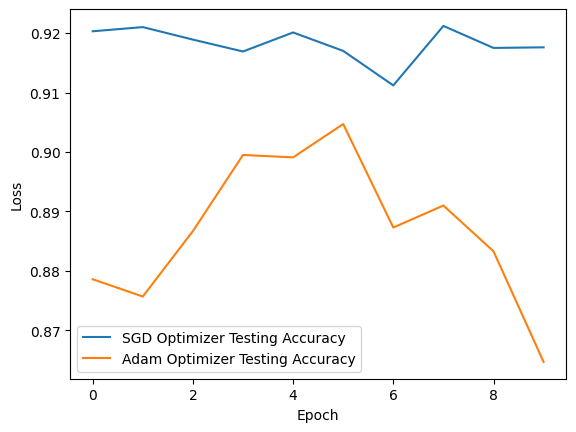

In [ ]:
# TODO: Replace SGD with Adam optimizer and compare convergence speed.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # adam optimizer with same hyperparameters
print("\nAdam optimizer:")
adam_trn_loss, adam_trn_acc, adam_test_loss, adam_test_acc = train_loop(0, 0)
plt.plot(SGD_test_acc, label="SGD Optimizer Testing Accuracy")
plt.plot(adam_test_acc, label="Adam Optimizer Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

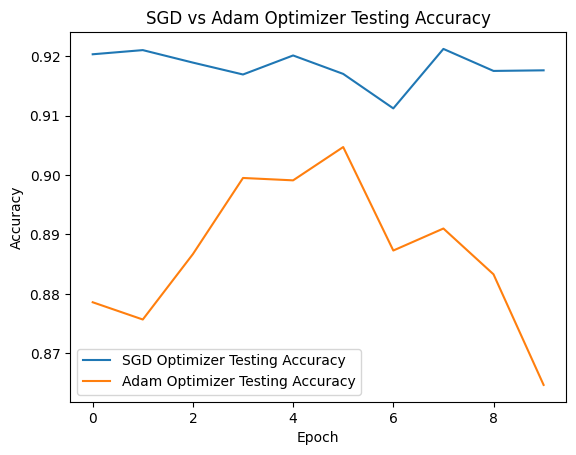

In [ ]:
#
# IGNORE THE CHART ABOVE !! it has incorrect ylabel
#

plt.plot(SGD_test_acc, label="SGD Optimizer Testing Accuracy")
plt.plot(adam_test_acc, label="Adam Optimizer Testing Accuracy")
plt.title("SGD vs Adam Optimizer Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### 5. Visualization of Learned Weights

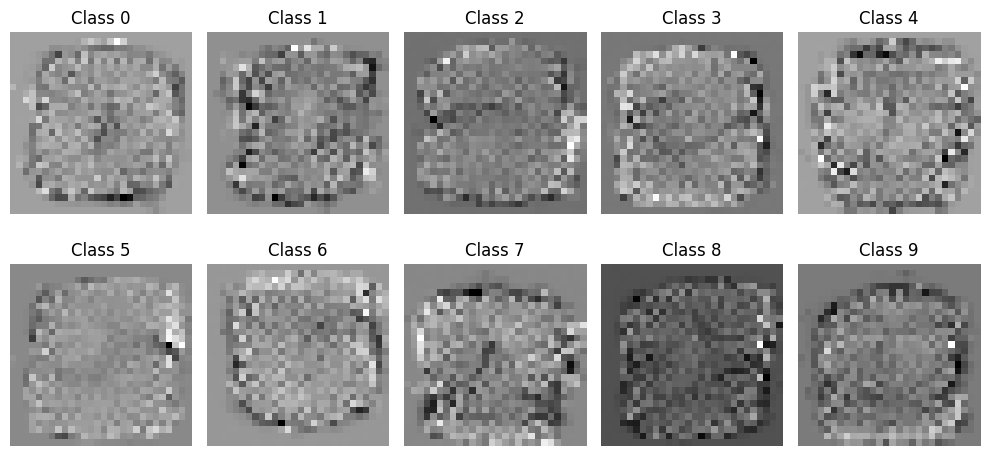

In [ ]:
# TODO: Plot each class’s weight vector as 28x28 image.

weights = model.fc.weight.detach().cpu().numpy() # from CGPT

fig = plt.figure(figsize=(10, 5))
for i in range(10):  # one image per class (digits 0–9)
    plt.subplot(2, 5, i+1)
    plt.imshow(weights[i].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(f"Class {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Part 2 — Take-Home (3%)

Extend your experiments and write a short (≈1 page) report.  
**Deadline:** One week after the lab.

### 1. Confusion Matrix

Epoch: 1 | Training Loss: 2.22317, Training Accuracy: 0.92382 | Test Loss: 3.26511, Test Accuracy: 0.91230 |
Epoch: 2 | Training Loss: 1.91649, Training Accuracy: 0.93050 | Test Loss: 3.14256, Test Accuracy: 0.91210 |
Epoch: 3 | Training Loss: 1.77803, Training Accuracy: 0.93268 | Test Loss: 3.06380, Test Accuracy: 0.91240 |
Epoch: 4 | Training Loss: 1.68300, Training Accuracy: 0.93342 | Test Loss: 3.00694, Test Accuracy: 0.91190 |
Epoch: 5 | Training Loss: 1.61320, Training Accuracy: 0.93400 | Test Loss: 2.95496, Test Accuracy: 0.91280 |
Epoch: 6 | Training Loss: 1.55556, Training Accuracy: 0.93488 | Test Loss: 2.90836, Test Accuracy: 0.91220 |
Epoch: 7 | Training Loss: 1.50694, Training Accuracy: 0.93488 | Test Loss: 2.87073, Test Accuracy: 0.91100 |
Epoch: 8 | Training Loss: 1.46955, Training Accuracy: 0.93472 | Test Loss: 2.84441, Test Accuracy: 0.91150 |
Epoch: 9 | Training Loss: 1.43392, Training Accuracy: 0.93496 | Test Loss: 2.81015, Test Accuracy: 0.90990 |
Epoch: 10 | Trainin

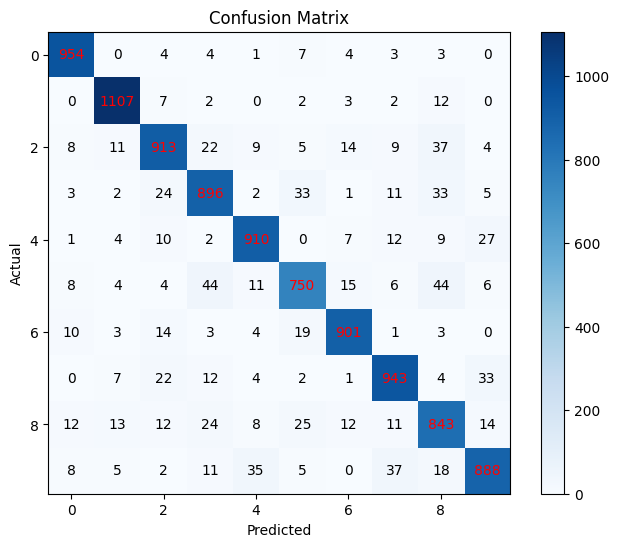

In [ ]:
# TODO: Compute confusion matrix on test set predictions.

# reset the model to baseline logistic regression
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
_, _, _, _ = train_loop(0, 1)

### 2. Reduced Training Data

with half training data:
25000  input/labels
Epoch: 1 | Training Loss: 1.85941, Training Accuracy: 0.44582 | Test Loss: 4.06032, Test Accuracy: 0.90290 |
Epoch: 2 | Training Loss: 1.62564, Training Accuracy: 0.45090 | Test Loss: 5.86502, Test Accuracy: 0.86420 |
Epoch: 3 | Training Loss: 1.57085, Training Accuracy: 0.44982 | Test Loss: 4.39396, Test Accuracy: 0.89340 |
Epoch: 4 | Training Loss: 1.64041, Training Accuracy: 0.44874 | Test Loss: 4.63508, Test Accuracy: 0.88940 |
Epoch: 5 | Training Loss: 1.49380, Training Accuracy: 0.45222 | Test Loss: 4.94478, Test Accuracy: 0.87950 |
Epoch: 6 | Training Loss: 1.44671, Training Accuracy: 0.45268 | Test Loss: 4.80610, Test Accuracy: 0.88090 |
Epoch: 7 | Training Loss: 1.55329, Training Accuracy: 0.45036 | Test Loss: 4.36763, Test Accuracy: 0.89550 |
Epoch: 8 | Training Loss: 1.38929, Training Accuracy: 0.45344 | Test Loss: 4.60186, Test Accuracy: 0.88660 |
Epoch: 9 | Training Loss: 1.40535, Training Accuracy: 0.45248 | Test Loss: 4.69307,

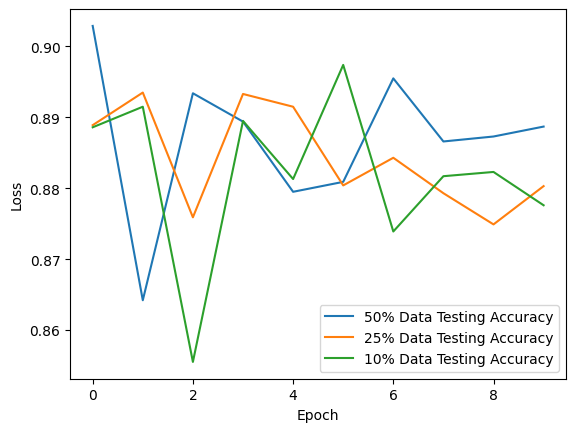

In [ ]:
# TODO: Train logistic regression with only 10%, 25%, 50% of train data.
# Plot validation accuracy vs dataset size.


# for 50% data
train_size_half = int(train_size / 2)
lost_data_size = len(train_ds) - train_size_half
train_ds_half, _ = random_split(train_ds, [train_size_half, lost_data_size])
train_loader = DataLoader(train_ds_half, batch_size=batch_size, shuffle=True)
print("with half training data:")
print(len(train_loader.dataset), " input/labels")
half_data_trn_loss, half_data_trn_acc, half_data_tst_loss, half_data_tst_acc = train_loop(0, 0)


# for 25% data
train_size_quarter = int(train_size / 4)
lost_data_size = len(train_ds) - train_size_quarter
train_ds_quarter, _ = random_split(train_ds, [train_size_quarter, lost_data_size])
train_loader = DataLoader(train_ds_quarter, batch_size=batch_size, shuffle=True)
print("with quarter training data:")
print(len(train_loader.dataset), " input/labels")
quarter_data_trn_loss, quarter_data_trn_acc, quarter_data_tst_loss, quarter_data_tst_acc = train_loop(0, 0)

# for 10% data
train_size_tenth = int(train_size / 10)
lost_data_size = len(train_ds) - train_size_tenth
train_ds_tenth, _ = random_split(train_ds, [train_size_tenth, lost_data_size])
train_loader = DataLoader(train_ds_tenth, batch_size=batch_size, shuffle=True)
print("with tenth training data")
print(len(train_loader.dataset),  " input/labels")
tenth_data_trn_loss, tenth_data_trn_acc, tenth_data_tst_loss, tenth_data_tst_acc = train_loop(0, 0)

plt.plot(half_data_tst_acc, label="50% Data Testing Accuracy")
plt.plot(quarter_data_tst_acc, label="25% Data Testing Accuracy")
plt.plot(tenth_data_tst_acc, label="10% Data Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



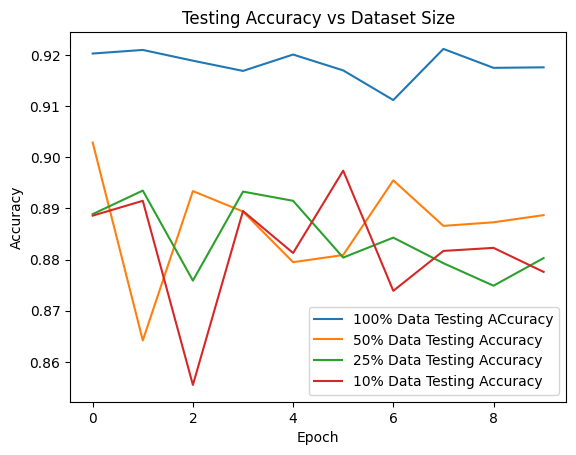

In [ ]:
#
# IGNORE THE CHART ABOVE !! it has incorrect ylabel
#

plt.plot(SGD_test_acc, label = '100% Data Testing ACcuracy')
plt.plot(half_data_tst_acc, label="50% Data Testing Accuracy")
plt.plot(quarter_data_tst_acc, label="25% Data Testing Accuracy")
plt.plot(tenth_data_tst_acc, label="10% Data Testing Accuracy")
plt.title("Testing Accuracy vs Dataset Size")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 3. Noisy Labels

In [ ]:
# from gemini

# Remember to first reset all the data to 100% training size
# Download MNIST again to get the original dataset
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

import random

num_classes = 10

# Number of noisy samples
num_noisy = int(0.1 * len(train_ds))

# Randomly select indices to corrupt
noisy_indices = random.sample(range(len(train_ds)), num_noisy)

# Modify the targets directly
for idx in noisy_indices:
    # Get the original target
    _, original_label = train_ds[idx]
    # Choose a wrong label
    wrong_label = random.choice([i for i in range(num_classes) if i != original_label])
    # Replace with noisy label
    train_ds.targets[idx] = wrong_label

# Now you can recreate the DataLoader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
print("with 10% of the training data as noisy labels:")
noisy_trn_loss, noisy_trn_acc, noisy_tst_loss, noisy_tst_acc = train_loop(0, 0)

with 10% of the training data as noisy labels:
Epoch: 1 | Training Loss: 16.64660, Training Accuracy: 0.68815 | Test Loss: 5.82620, Test Accuracy: 0.72390 |
Epoch: 2 | Training Loss: 10.15712, Training Accuracy: 0.68090 | Test Loss: 5.23185, Test Accuracy: 0.67680 |
Epoch: 3 | Training Loss: 8.23063, Training Accuracy: 0.67935 | Test Loss: 4.76711, Test Accuracy: 0.71260 |
Epoch: 4 | Training Loss: 7.47397, Training Accuracy: 0.67723 | Test Loss: 3.24788, Test Accuracy: 0.75690 |
Epoch: 5 | Training Loss: 6.81961, Training Accuracy: 0.67755 | Test Loss: 3.13828, Test Accuracy: 0.72450 |
Epoch: 6 | Training Loss: 6.48541, Training Accuracy: 0.67270 | Test Loss: 3.77999, Test Accuracy: 0.70700 |
Epoch: 7 | Training Loss: 6.21969, Training Accuracy: 0.67453 | Test Loss: 3.06329, Test Accuracy: 0.73460 |
Epoch: 8 | Training Loss: 5.96543, Training Accuracy: 0.67175 | Test Loss: 3.41514, Test Accuracy: 0.71520 |
Epoch: 9 | Training Loss: 6.06396, Training Accuracy: 0.66945 | Test Loss: 3.34

### 4. Short Report

- Which regularization worked better (L1 vs L2)?  
- Which optimizer was more effective (SGD vs Adam)?  
- What does the confusion matrix reveal?  
- How does performance degrade with reduced or noisy data?  
- How did Gemini help (include sample prompts + modifications)?